In [1]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
eqsys = pyequion2.EquilibriumBackend(["Ca", "C", "Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [51]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'C':0.065, 'Ca':0.028, 'Na':0.075, 'Cl':0.056}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Calcite"],
                           kreaction="inf")
builder.make_grid(10, 5)
builder.set_species()

In [52]:
builder.set_initial_guess_from_bulk()

In [53]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success#, solfull.success

True

In [54]:
builder.simplified = False

def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=False, include_mu=False)
    return res.flatten()

def flat_objective(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.gibbs_free_energy(logcmu)
    return res.flatten()[0]
    
def torch_wrap(f):
    def g(x):
        x = torch.tensor(x, dtype=torch.float)
        res = f(x).detach().numpy()
        return res
    return g

def torch_wrap(f):
    def g(*args):
        args = [torch.tensor(arg, dtype=torch.float) for arg in args]
        res = f(*args).detach().numpy()
        return res
    return g

In [55]:
def make_lagrangian_residual_jacobian(g, df, dg, d2f, d2g, nx, nlambd):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = np.concatenate([res1, res2], axis=-1)
        return res
    def jacobian(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        jac11 = d2f(x) - d2g(x, lambd)
        jac12 = -dg(x).T
        jac21 = dg(x)
        jac22 = np.zeros([nlambd, nlambd])
        jac = np.block([[jac11, jac12], [jac21, jac22]])
        return jac
    return residual, jacobian

def make_lagrangian_residual(g, df, dg, nx):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = torch.cat([res1, res2], dim=-1)
        return res
    return residual

def make_lagrangian_residual_torch(g, df, dg, nx, nlambd):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = torch.cat([res1, res2], axis=-1)
        return res
    return residual

In [56]:
f_t = flat_objective
df_t = functorch.jacrev(f_t)
d2f_t = functorch.hessian(f_t)
g_t = flat_residual
dg_t = functorch.jacrev(g_t)
d2g_t = functorch.jacrev(lambda x, v : (dg_t(x).T)@v)
f = torch_wrap(f_t)
df = torch_wrap(df_t)
d2f = torch_wrap(d2f_t)
g = torch_wrap(g_t)
dg = torch_wrap(dg_t)
d2g = torch_wrap(d2g_t)

equality_constraint = scipy.optimize.NonlinearConstraint(
    g, lb=0.0, ub=0.0, jac = dg, hess=d2g)
x0 = builder.x.detach().numpy()
# lambd0 = builder.lambd.detach().numpy()
# xlambd0 = np.concatenate([x0, lambd0], axis=0)

In [57]:
b = df(x0)
A = dg(x0).T
lambd0, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
xlambd0 = np.concatenate([x0, lambd0], axis=0)
xlambd0_t = torch.tensor(xlambd0, dtype=torch.float)

In [58]:
h, dh = make_lagrangian_residual_jacobian(g, df, dg, d2f, d2g, len(builder.x), len(builder.lambd))
h_t = make_lagrangian_residual_torch(g_t, df_t, dg_t, len(builder.x), len(builder.lambd))
loss_t = lambda x : torch.sum(h_t(x)**2)
dloss_t = functorch.grad(loss_t)
d2loss_t = functorch.hessian(loss_t)
loss = torch_wrap(loss_t)
dloss = torch_wrap(dloss_t)
d2loss = torch_wrap(d2loss_t)

In [59]:
sol = scipy.optimize.minimize(loss, xlambd0, jac=dloss, method='TNC',
                              hess=d2loss) #TNC
print(sol.success)
print(sol.fun)

/home/dfnaiff/miniconda3/envs/mainenv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:527: RuntimeWarning: Method TNC does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


False
0.014529818


In [60]:
xlambd0 = sol.x
sol = scipy.optimize.minimize(loss, xlambd0, jac=dloss, method='BFGS',
                              hess=d2loss) #TNC
print(sol.success)
print(sol.fun)

/home/dfnaiff/miniconda3/envs/mainenv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:527: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


False
0.0002884948917198926


In [61]:
# xlambd0_t.requires_grad = True
# optimizer = torch.optim.SGD([xlambd0_t], lr=1e-6, momentum=0.9)
# for i in range(1000):
#     loss = torch.max(h_t(xlambd0_t)**2)
#     loss.backward()
#     optimizer.step()
#     print(loss)

In [62]:
# sol = scipy.optimize.root(h, xlambd0, jac=dh, method="broyden1")
# print(sol.success)
# print(np.max(np.abs(sol.fun)))

In [63]:
x = sol.x[:len(builder.x)]

In [64]:
logcmu = x.reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

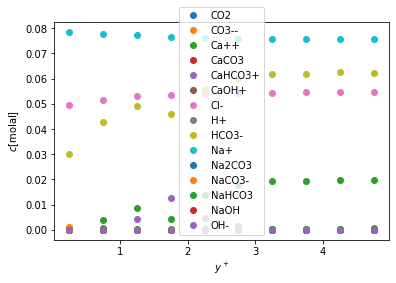

In [65]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

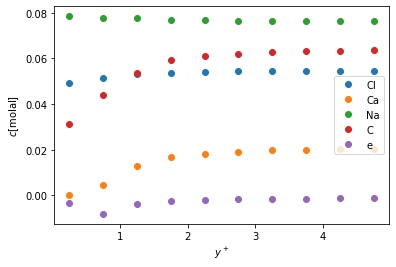

In [66]:
cel = builder.reduced_formula_matrix.numpy()@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

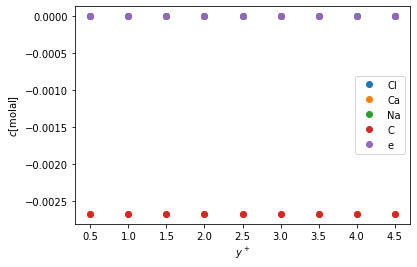

In [68]:
fluxes = builder.fluxes().detach().numpy()
yplot = builder.ypoints[1:-1].detach().numpy()
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(yplot, fluxes[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [69]:
4/(1e-2)*builder.fluxes()

tensor([[-4.4822e-06, -4.1490e-06,  5.9151e-06,  2.4973e-06, -3.6332e-07,
         -1.3239e-05,  7.7382e-06,  7.0530e-06,  2.6764e-05],
        [-1.0680e+00, -1.0680e+00, -1.0680e+00, -1.0680e+00, -1.0680e+00,
         -1.0680e+00, -1.0680e+00, -1.0680e+00, -1.0680e+00],
        [-4.7632e-06, -1.9762e-07,  5.0540e-07, -6.0564e-06,  9.6512e-06,
         -2.4432e-05,  2.0087e-05,  4.0688e-05,  1.1733e-05],
        [-1.0680e+00, -1.0680e+00, -1.0680e+00, -1.0680e+00, -1.0680e+00,
         -1.0680e+00, -1.0681e+00, -1.0681e+00, -1.0680e+00],
        [ 7.1643e-07,  1.3362e-06, -2.4124e-06, -1.6742e-05,  2.1516e-05,
         -1.8337e-05,  1.4196e-05,  6.1934e-05,  3.7368e-06]])